# 05 - Unsupervised clustering via SOM

author: jake siegel

date: 1.22.2018

The purpose of this notebook is to explore methods for unsupervised clustering of the Karlsson TPM data with the goal of determining whether there is a more natural number of cell cycle stages in trancriptome data than the 3 cytological stages.  

In the Karlsson paper, they did tSNE of all genes observed in at least 15 cells to make a timeline and did pairwise correlations.  They determined that there early and late G1 are effectively unique and that there are essentially 6 classes of gene expression through a cell cycle.  Leng et al. perform a similar analysis with a custom algorithm on a transcriptome dataset of 490 asychronous hESC cells.

The next few notebooks ivestigate how many cell clusters the transcriptome data naturally form using tSNE, self organizing maps and hdbscan.  An autoencoder will be implemented to reduce dimensionality for tSNE and HDBCSAN.

Initially, the Karlsson data will be used, however the Leng data should also be utilized.

This notebook is to investigate unsupervised clustering via SOM.

### Status: Ongoing 1/26
I still need to figure out how to build the neuron space into an edgeless toroid and display the relative distances between neurons.  Alterantively, I could implement the U* Matrix R package from Alfred Ultsch, which is supposed to be able to do both.

In [5]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Self Organizing Map:

This section contains the code to build a SOM in tensorflow.  Adapted from:

https://github.com/spiglerg/Kohonen_SOM_Tensorflow/blob/master/som.py

https://github.com/BinRoot/TensorFlow-Book/blob/master/ch05_clustering/som.py

https://wonikjang.github.io/deeplearning_unsupervised_som/2017/06/30/som.html

https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/

In [6]:
# My SOM

class SOM:
    def __init__(self, width, height, dim, n_iter, alpha = None, sigma = None):
        #         assign parameters:
        self.n_iter = n_iter
        self.width = width
        self.height = height
        self.dim = dim # dimension of input data
#         self.locs = self.get_locs()
        
        #         setting defaults if not specified
        if alpha is None: # learning rate
            self.alpha = 0.2
        else:
            self.alpha = tf.to_float(alpha)
        if sigma is None: # neighborhood influence
            self.sigma = max(width, height) / 2.0
        else:
            self.sigma = tf.to_float(sigma)
        
        #         Initialize graph:
        self.initialize_graph()
        
    def initialize_graph(self):
        #   initialize weight vectors:
        self.weights = tf.Variable(tf.random_normal([self.width*self.height,self.dim]))
        
#         self.locations = tf.constant(np.array(list(self.locs(self.width,self.height))))
        self.locations = tf.constant(np.array(list(self.locs())))
        #         self.locations = tf.constant(self.locs)
        
        #   initialize placeholders for training vector and current iteration
        self.input_vector = tf.placeholder(tf.float32, [self.dim])
        self.curr_iter = tf.placeholder(tf.float32)
        
        #   The training operation:
        #   Compute the closest weight vector to each input for each neuron
        self.bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
            tf.pow(tf.subtract(self.weights,tf.stack([self.input_vector for 
                                               i in range(self.width*self.height)])),2),1)),0)
#         self.bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
#             tf.pow(tf.subtract(self.weights,tf.stack([self.input_vector for 
#                                                i in range(600)])),2),1)),0)
 
        #   Get the location of the BMU
        self.bmu_sliced = tf.pad(tf.reshape(self.bmu_index,[1]),np.array([[0,1]]))
        self.bmu_loc = tf.reshape(tf.slice(self.locations, self.bmu_sliced,
                                          tf.constant(np.array([1,2]))),[2])
        
        #   update learning rate & neighborhood influence:
        self.lr_update = tf.subtract(1.0, tf.divide(self.curr_iter, self.n_iter))
        self.alpha_update = tf.multiply(self.alpha, self.lr_update)
        self.sigma_update = tf.multiply(self.sigma, self.lr_update)
        
        #   Generate learning rate vectors for all neurons
        self.bmu_dist_sq = tf.cast(tf.reduce_sum(tf.pow(tf.subtract(self.locations, 
                                    tf.stack([self.bmu_loc for i in range(self.width*self.height)])),
                                                        2),1),"float32")
        self.neighborhood = tf.exp(tf.negative(tf.divide(self.bmu_dist_sq, tf.pow(self.sigma_update,2))))
        self.lr_update = tf.multiply(self.alpha_update, self.neighborhood)
        
        #   Update the weights vector:
        #   w_delta = L(t) * ( V(t)-W(t) )
        self.lr_multiplier = tf.stack([tf.tile(tf.slice(
            self.lr_update, np.array([i]), np.array([1])),[self.dim])
                                     for i in range(self.width* self.height)])
        self.w_delta = tf.multiply(self.lr_multiplier, tf.subtract(tf.stack(
                [self.input_vector for i in range(self.width*self.height)]),
                self.weights))
        self.weights_update = tf.assign_add(self.weights, self.w_delta)
        
        #   Initialize:
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    
    def locs(self):
#         locs = [[x, y]
#                 for y in range(self.height)
#                 for x in range(self.width)]
#         return tf.to_float(locs)
        for i in range(self.width):
            for j in range(self.height):
                yield np.array([i, j])

    
    def train(self,x_inputs):
        for iter_num in range(self.n_iter):
            for x_input in x_inputs:
                self.sess.run(self.weights_update, 
                              {self.input_vector: x_input, self.curr_iter: iter_num})
        
        #  Store the centroid grid to map inputs to their closest neurons at the end
        centroid_grid = [[] for i in range(self.width)]
        self.weight_vectors = list(self.sess.run(self.weights))
        self.loc_vectors = list(self.sess.run(self.locations))
        for i,loc in enumerate(self.loc_vectors):
            centroid_grid[loc[0]].append(self.weight_vectors[i])
        self.centroids = centroid_grid
        
    def get_centroids(self):
        if not self.centroids:
            raise ValueError('Not trained yet')
        return self.centroids
    
    def map_to_vector(self, x_inputs):
        if not self.centroids:
            raise ValueError('Not trained yet')
        
        output = []
        for vec in x_inputs:
            neuron = min([i for i in range(len(self.weight_vectors))],
                         key = lambda x: np.linalg.norm(vec-self.weight_vectors[x]))
            output.append(self.locations[neuron].eval(session=self.sess))
        
        return output

2018-01-24 12:31:24.858337 Training SOM
2018-01-24 12:32:21.895603 Getting output grid
2018-01-24 12:32:21.896046 Mapping inputs
2018-01-24 12:32:34.674275 Plotting


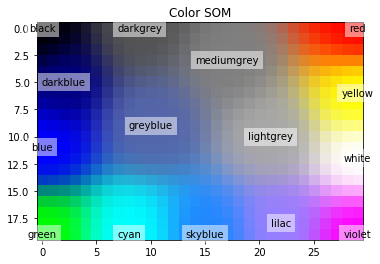

In [97]:
# Testing cell

#Training inputs for RGBcolors
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = ['black', 'blue', 'darkblue', 'skyblue', 'greyblue', 'lilac', 'green', 'red',
               'cyan', 'violet', 'yellow', 'white', 'darkgrey', 'mediumgrey', 'lightgrey']

print str(datetime.datetime.now()),'Training SOM'
#Train a 20x30 SOM with 400 iterations
som = SOM(20, 30, 3, 400)
som.train(colors)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(colors)
 
print str(datetime.datetime.now()),'Plotting'    
#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))

In [95]:
image_grid[0][0]

array([0.00233568, 0.9913497 , 0.9999973 ], dtype=float32)

The training took about 60s.  From the Peng & Nie paper, they suggest the time complexity is O(N_samples*N_neurons*Dimension_sample*Iterations)

For this example, that should be O(15*600*3*400) = O(10.8e6)

so as a rough guide, I'd estimate O(200,000)/s.

For the Karlsson data, it would be:
N_sample = 96
Dimension_sample = ~13566 (at the 8-cell detection cut-off)
Iterations = Keep this as a multiplicative factor since I have no idea how many it will take
N_neurons = 100 to 400 (rough guide is 10 per expected class)

So, that's 130,000,000 * (1 to 4) * Iterations = 600s * (1 to 4) * Iterations 
so roughly 10 to 40 min per iteration, which is multiple days.

I should get about 960 minutes if I start around 3pm.  So, that would be:
O(1e10)= O(1e8=Dim*N_Neurons*Iter)
To keep 10,000 transcripts, leaves me with 1e4 to split between N_Neurons and Iter, which is not many
ideally, I'd keep a 15x15 network = 400 neurons
so 225 neurons, 250 iterations, 2000 dimensions


## Testing on the Karlsson TPM data:

In [7]:
import pandas as pd

data_src = '../data/processed/KarlssonTPM.csv'
df = pd.read_csv(data_src, sep = '\t')
df = df.set_index(list(df.columns)[0])
df = df.drop(['bp'],axis=0)
df.Stage = pd.factorize(df.Stage)[0]

In [113]:
# I think the cut to 1000 genes is about 92 cells

keepcols = []

for column in df.iloc[:,:-1]:
    if df[column].astype(bool).sum(axis=0)>92:
        keepcols.append(column)
        
print len(keepcols)
    
y = df['Stage']   
X = df[keepcols]

X.head()

2230


,ENSG00000000003.10,ENSG00000000419.8,ENSG00000001630.11,ENSG00000002330.9,ENSG00000002549.7,ENSG00000003056.3,ENSG00000004059.6,ENSG00000004455.12,ENSG00000004478.5,ENSG00000004779.5,...,ENSG00000267855.1,ENSG00000268032.2,ENSG00000268034.1,ENSG00000268412.1,ENSG00000269028.2,ENSG00000269378.1,ENSG00000270170.1,ENSG00000270532.1,ENSG00000271043.1,ENSG00000271525.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
S1,214.562861,125.703774,29.081103,245.458430,118.230417,166.973054,128.081279,62.329866,158.911966,277.815131,...,214.392290,34.698545,44.002461,70.895730,15.468159,185.668709,465.477013,32.987651,10.143055,38.884836
S10,168.206876,114.957657,4.112124,130.566751,237.925925,184.130451,504.436902,130.060544,118.393620,251.900511,...,178.146428,19.876244,66.755499,14.378996,18.692695,105.965408,159.766621,31.541023,2.828655,10.844049
S11,382.458887,227.095259,13.993596,189.056312,210.922546,76.533409,209.668068,66.988668,110.271928,485.496305,...,136.483873,12.537213,36.602770,4.786812,22.976697,83.380131,255.296631,14.000138,3.766672,7.220034
S12,144.523522,153.222825,10.795709,347.440826,55.851820,41.075402,244.194797,87.618050,74.393724,113.556225,...,126.854076,40.372257,60.308561,50.962099,16.987366,64.490625,181.198573,24.841740,2.227851,25.622349
S13,275.373491,220.168037,0.967177,135.061984,126.729410,93.875083,288.037868,81.093412,115.950262,224.516103,...,92.984128,14.762895,60.956723,30.437615,15.218808,59.475799,99.204079,12.982352,3.991818,13.390300


In [114]:
# Training the Karlsson TPM data (transcripts found in >92 cells)

print str(datetime.datetime.now()),'Training SOM'
#Train a 15x15 SOM with 250 iterations
som = SOM(15, 15, 2230, 250)
som.train(X.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(X.values)
 
# print str(datetime.datetime.now()),'Plotting'    
# #Plot
# plt.imshow(image_grid)
# plt.title('Color SOM')
# for i, m in enumerate(mapped):
#     plt.text(m[1], m[0], color_names[i], ha='center', va='center',
#              bbox=dict(facecolor='white', alpha=0.5, lw=0))

2018-01-24 14:37:48.858783 Training SOM
2018-01-24 14:43:58.439592 Getting output grid
2018-01-24 14:43:58.441176 Mapping inputs


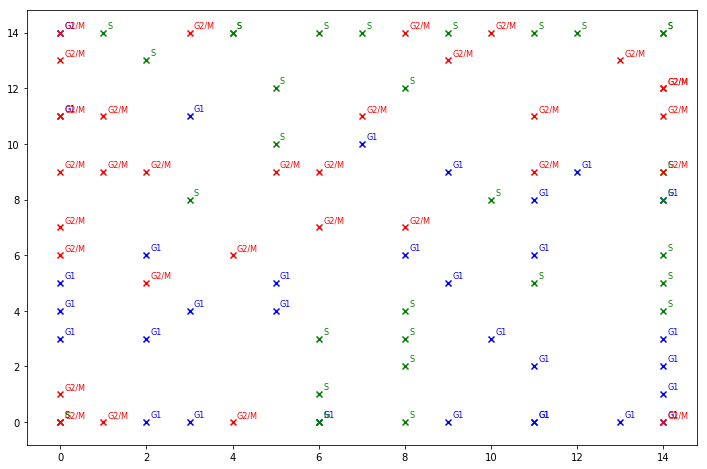

In [134]:
colormap = ['blue','green','red']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], marker = 'x')
    ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
        color=colormap[y.values[i]], fontsize=8)
    
# y.values[12]
# colormap[y.values[40]]

Interesting, that only took 5 minutes.  I guess training takes less time than setting up the SOM.  Let's test a few things (number of neurons, iterations) and then try it with the big dataset:

In [8]:
# I think the cut to 1000 genes is about 92 cells
def columns_min_detect(df_temp,minimum_cells):
    keepcols = []
    for column in df_temp.iloc[:,:-1]:
        if df_temp[column].astype(bool).sum(axis=0)>minimum_cells:
            keepcols.append(column)
    return keepcols
        
# print len(keepcols)
    
# y = df['Stage']   
# X = df[keepcols]

# X.head()

In [138]:
y = df['Stage']
use_cols = columns_min_detect(df,92)
X = df[use_cols]

X.head()

,ENSG00000000003.10,ENSG00000000419.8,ENSG00000001630.11,ENSG00000002330.9,ENSG00000002549.7,ENSG00000003056.3,ENSG00000004059.6,ENSG00000004455.12,ENSG00000004478.5,ENSG00000004779.5,...,ENSG00000267855.1,ENSG00000268032.2,ENSG00000268034.1,ENSG00000268412.1,ENSG00000269028.2,ENSG00000269378.1,ENSG00000270170.1,ENSG00000270532.1,ENSG00000271043.1,ENSG00000271525.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
S1,214.562861,125.703774,29.081103,245.458430,118.230417,166.973054,128.081279,62.329866,158.911966,277.815131,...,214.392290,34.698545,44.002461,70.895730,15.468159,185.668709,465.477013,32.987651,10.143055,38.884836
S10,168.206876,114.957657,4.112124,130.566751,237.925925,184.130451,504.436902,130.060544,118.393620,251.900511,...,178.146428,19.876244,66.755499,14.378996,18.692695,105.965408,159.766621,31.541023,2.828655,10.844049
S11,382.458887,227.095259,13.993596,189.056312,210.922546,76.533409,209.668068,66.988668,110.271928,485.496305,...,136.483873,12.537213,36.602770,4.786812,22.976697,83.380131,255.296631,14.000138,3.766672,7.220034
S12,144.523522,153.222825,10.795709,347.440826,55.851820,41.075402,244.194797,87.618050,74.393724,113.556225,...,126.854076,40.372257,60.308561,50.962099,16.987366,64.490625,181.198573,24.841740,2.227851,25.622349
S13,275.373491,220.168037,0.967177,135.061984,126.729410,93.875083,288.037868,81.093412,115.950262,224.516103,...,92.984128,14.762895,60.956723,30.437615,15.218808,59.475799,99.204079,12.982352,3.991818,13.390300


2018-01-24 15:12:37.621812 Training SOM
2018-01-24 15:23:54.717603 Getting output grid
2018-01-24 15:23:54.718761 Mapping inputs


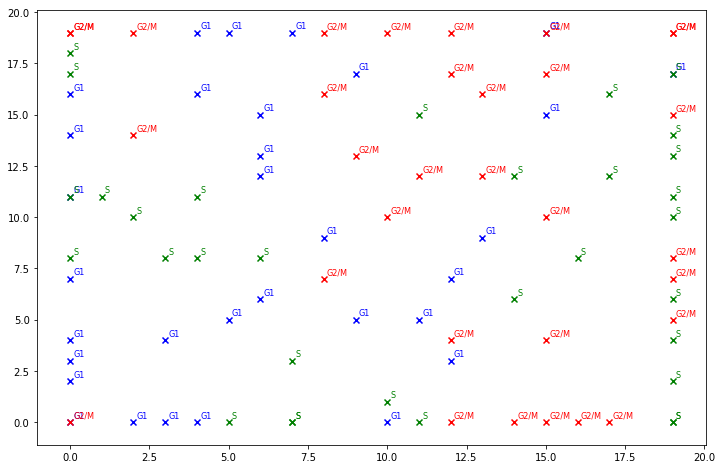

In [139]:
# Training the Karlsson TPM data (transcripts found in >92 cells, 400 neurons, 250 iterations)

print str(datetime.datetime.now()),'Training SOM'
#Train a 15x15 SOM with 250 iterations
som = SOM(20, 20, X.shape[1], 250)
som.train(X.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(X.values)
 
colormap = ['blue','green','red']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], marker = 'x')
    ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
        color=colormap[y.values[i]], fontsize=8)


2018-01-24 15:28:42.129754 Training SOM
2018-01-24 15:47:09.708838 Getting output grid
2018-01-24 15:47:09.710286 Mapping inputs


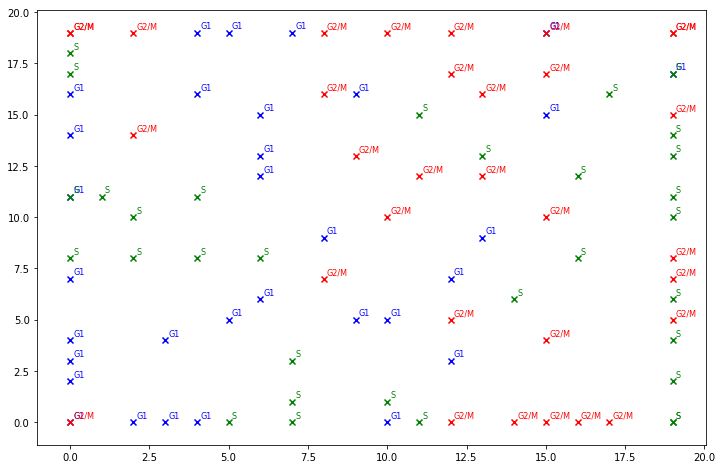

In [140]:
# Training the Karlsson TPM data (transcripts found in >92 cells, 400 neurons, 400 iterations)

print str(datetime.datetime.now()),'Training SOM'
#Train a 20x20 SOM with 400 iterations
som = SOM(20, 20, X.shape[1], 400)
som.train(X.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(X.values)
 
colormap = ['blue','green','red']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], marker = 'x')
    ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
        color=colormap[y.values[i]], fontsize=8)



2018-01-24 15:53:54.012657 Training SOM
2018-01-24 17:20:47.586914 Getting output grid
2018-01-24 17:20:47.592125 Mapping inputs


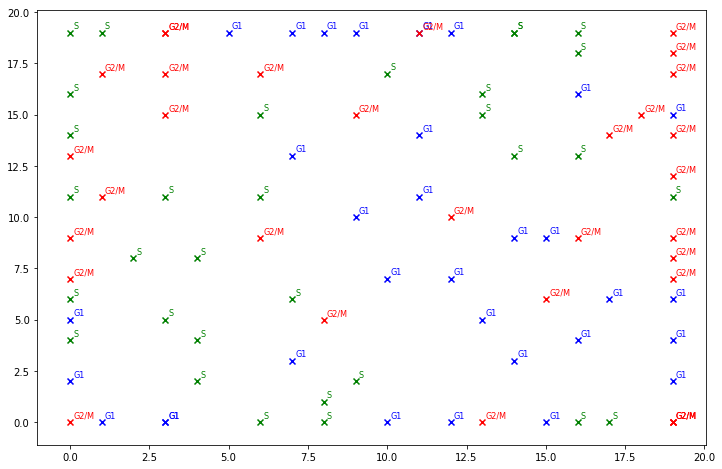

In [141]:
# Doesn't seem to have changed anything at all.  OK, now let's try it on the full dataset:
# transcripts found in > 8 cells, 20 x 20 ANN, 400 iterations

y = df['Stage']
use_cols = columns_min_detect(df,8)
X = df[use_cols]

print str(datetime.datetime.now()),'Training SOM'
#Train a 20x20 SOM with 400 iterations
som = SOM(20, 20, X.shape[1], 400)
som.train(X.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(X.values)
 
colormap = ['blue','green','red']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], marker = 'x')
    ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
        color=colormap[y.values[i]], fontsize=8)

2018-01-25 10:33:41.471790 Training SOM
2018-01-25 10:43:37.885909 Getting output grid
2018-01-25 10:43:37.892655 Mapping inputs


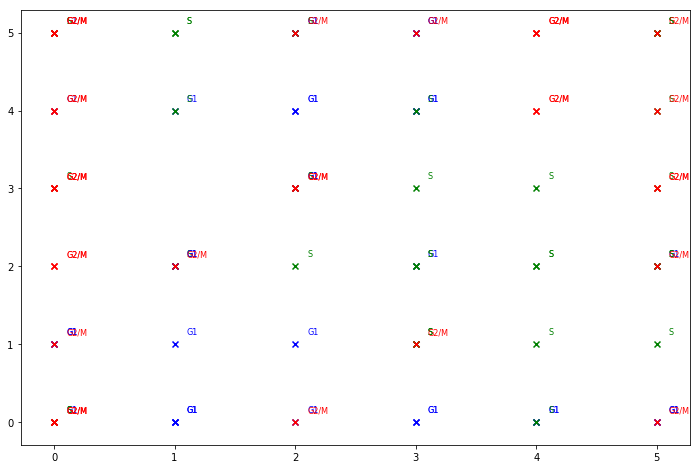

In [18]:
# Maybe I just have too many neurons.  
# I am effectively able to map each data point to an individual neuron and allow space between them.
# Let's try this with 36 neurons: 6x6

y = df['Stage']
use_cols = columns_min_detect(df,8)
X = df[use_cols]

print str(datetime.datetime.now()),'Training SOM'
#Train a 6x6 SOM with 500 iterations
som = SOM(6, 6, X.shape[1], 500)
som.train(X.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(X.values)
 
colormap = ['blue','green','red']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], marker = 'x')
    ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
        color=colormap[y.values[i]], fontsize=8)

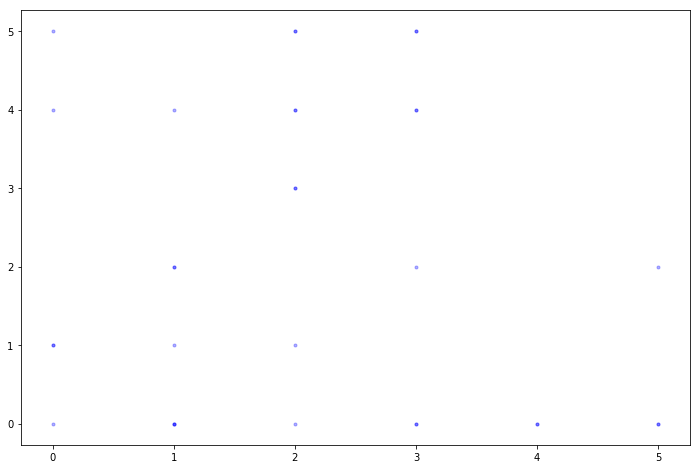

In [39]:
colormap = ['blue','green','red']
marks = ['.','None','None']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], alpha = 0.3,
                     marker = marks[y.values[i]])
#     ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
#         color=colormap[y.values[i]], fontsize=8)

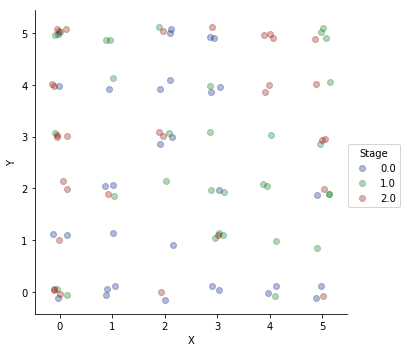

In [61]:
cols = ['X','Y','Stage']
temp = pd.DataFrame()
for i,m in enumerate(mapped):
    temp = temp.append(pd.Series([m[1],m[0],y.values[i]]), ignore_index=True)

temp.columns = cols
# temp
import seaborn as sns
sns.lmplot(x='X',y='Y',data = temp, fit_reg=False,hue='Stage',x_jitter=0.15, y_jitter=0.15, scatter_kws={'alpha':0.3},palette = 'dark')


# Summary 

Unsurprisingly, the simple SOM does not seem to cluster wonderfully.  The biggest limitations are the edge effects and not having figured out yet how to map the distance between neurons onto a 2D visualization.

To solve the first problem, people use toroidal shaped spaces (i.e. no edges).  I need to look into how to implement this. 

For the second problem, from the image_grid, I get a position of each neuron in n_transcript dimensions.  It's pretty easy to get the euclidean distance between any 2, but then I need to figure out how to display the relative distances between 3 neurons and then how to do it for the 4 neighboring neurons.

Alternatively, there is an R-package from Alfred Ultsch's group in Marburg called U*matrix that should handle both issues. 

In [73]:
print len(image_grid[0][0])

image_grid

13566


[[array([2.3054024e+02, 1.2487348e+02, 3.3017013e+00, ..., 1.1327887e-01,
         4.8610342e-01, 8.3257666e+00], dtype=float32),
  array([1.7351125e+02, 2.1740848e+02, 6.8174726e-01, ..., 2.6705735e+00,
         8.5337809e-04, 5.8470607e+00], dtype=float32),
  array([2.1237868e+02, 9.8454872e+01, 6.6681480e-01, ..., 1.2308511e-02,
         5.8977730e-06, 5.6183476e+00], dtype=float32),
  array([5.6022070e+02, 2.8326306e+02, 2.2590647e+01, ..., 4.4422573e-04,
         2.0271454e-03, 4.7675538e+00], dtype=float32),
  array([3.8174191e+02, 1.9147467e+02, 1.0732659e+01, ..., 2.9846710e-06,
         4.7257072e-01, 4.2447720e+00], dtype=float32),
  array([3.0206970e+02, 1.5599899e+02, 9.8956451e-03, ..., 3.9327330e-07,
         4.2312386e-04, 6.5236173e+00], dtype=float32)],
 [array([4.2993954e+02, 5.8103893e+01, 3.4555620e-01, ..., 1.0854754e-01,
         8.4602332e-04, 2.8174171e+00], dtype=float32),
  array([2.1310709e+02, 1.3236858e+02, 4.8986867e-01, ..., 8.6862706e-02,
         3.2332

##  Scratch space

2018-01-24 23:03:01.086521 Training SOM
2018-01-25 00:30:33.141982 Getting output grid
2018-01-25 00:30:33.142619 Mapping inputs


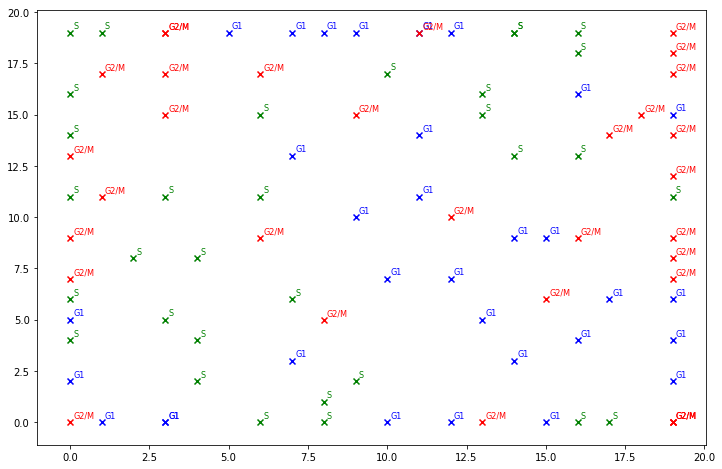

In [17]:
# OK, let's try it on scaled data now.
from sklearn.preprocessing import RobustScaler
y = df['Stage']
use_cols = columns_min_detect(df,8)
X = df[use_cols]

X_scaled = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(X))

print str(datetime.datetime.now()),'Training SOM'
#Train a 20x20 SOM with 400 iterations
som = SOM(20, 20, X.shape[1], 400)
som.train(X.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(X.values)
 
colormap = ['blue','green','red']
cyt = ['G1','S','G2/M']
fig, ax = plt.subplots(figsize=[12,8])
for i,m in enumerate(mapped):
    ax = plt.scatter(m[1], m[0], color = colormap[y.values[i]], marker = 'x')
    ax = plt.text(m[1]+0.1,m[0]+0.1, cyt[y.values[i]],verticalalignment='bottom', horizontalalignment='left',
        color=colormap[y.values[i]], fontsize=8)

In [11]:
X.head()

,ENSG00000000003.10,ENSG00000000419.8,ENSG00000000457.8,ENSG00000000460.12,ENSG00000001036.8,ENSG00000001084.6,ENSG00000001167.10,ENSG00000001460.13,ENSG00000001461.12,ENSG00000001497.12,...,ENSG00000271335.1,ENSG00000271426.1,ENSG00000271430.1,ENSG00000271525.1,ENSG00000271533.1,ENSG00000271576.1,ENSG00000271585.1,ENSG00000271614.1,ENSG00000271625.1,ENSG00000271707.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
S1,214.562861,125.703774,0.756280,54.040882,227.949411,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,38.884836,0.000000,18.067119,0.000000,0.362003,0.000000,3.202908
S10,168.206876,114.957657,0.421817,53.547315,177.908168,0.000000,0.000000,0.000000,19.534027,5.353793,...,0.0,0.00000,0.000000,10.844049,0.000000,40.307891,0.000000,0.000000,0.000000,1.786428
S11,382.458887,227.095259,0.561697,21.525815,138.675921,0.000000,0.000000,14.933325,23.517473,47.652919,...,0.0,3.02325,0.000000,7.220034,0.000000,1.219875,0.000000,0.000000,0.000000,4.757660
S12,144.523522,153.222825,0.332223,8.222587,0.000000,0.908844,0.000000,0.000000,3.582813,133.601311,...,0.0,0.00000,9.781794,25.622349,0.000000,2.886048,0.000000,0.636091,0.000000,4.220978
S13,275.373491,220.168037,31.251736,12.356763,51.437768,0.000000,70.060026,0.000000,6.797234,65.015447,...,0.0,0.00000,0.000000,13.390300,0.280836,0.000000,2.915152,0.000000,1.441336,5.042041


In [16]:
pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7,8,9,...,13556,13557,13558,13559,13560,13561,13562,13563,13564,13565
0,-0.131176,-0.222949,0.552513,1.329901,1.289138,0.000000,-0.060797,0.000000,-0.588365,-0.794051,...,0.0,0.00000,0.000000,1.872085,0.000000,22.480193,0.000000,0.362003,0.000000,-0.254064
1,-0.515231,-0.313086,0.128258,1.313329,0.820790,0.000000,-0.060797,0.000000,0.095990,-0.684676,...,0.0,0.00000,0.000000,-0.246024,0.000000,50.153494,0.000000,0.000000,0.000000,-0.632879
2,1.259825,0.627513,0.305690,0.238149,0.453606,0.000000,-0.060797,1.222626,0.235546,0.179466,...,0.0,3.02325,0.000000,-0.519770,0.000000,1.517841,0.000000,0.000000,0.000000,0.161730
3,-0.711445,0.007878,0.014612,-0.208531,-0.844294,0.908844,-0.060797,0.000000,-0.462845,1.935332,...,0.0,0.00000,9.781794,0.870280,0.000000,3.590995,0.000000,0.636091,0.000000,0.018203
4,0.372634,0.569408,39.234942,-0.069718,-0.362876,0.000000,2.175040,0.000000,-0.350231,0.534170,...,0.0,0.00000,0.000000,-0.053689,0.280836,0.000000,2.915152,0.000000,1.441336,0.237783


In [ ]:
class SOM(object):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
 
    #To check if the SOM has been trained
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Initializes all necessary components of the TensorFlow
        Graph.
 
        m X n are the dimensions of the SOM. 'n_iterations' should
        should be an integer denoting the number of iterations undergone
        while training.
        'dim' is the dimensionality of the training inputs.
        'alpha' is a number denoting the initial time(iteration no)-based
        learning rate. Default value is 0.3
        'sigma' is the the initial neighbourhood value, denoting
        the radius of influence of the BMU while training. By default, its
        taken to be half of max(m, n).
        """
 
        #Assign required variables first
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        ##INITIALIZE GRAPH
        self._graph = tf.Graph()
 
        ##POPULATE GRAPH WITH NECESSARY COMPONENTS
        with self._graph.as_default():
 
            ##VARIABLES AND CONSTANT OPS FOR DATA STORAGE
 
            #Randomly initialized weightage vectors for all neurons,
            #stored together as a matrix Variable of size [m*n, dim]
            self._weightage_vects = tf.Variable(tf.random_normal(
                [m*n, dim]))
 
            #Matrix of size [m*n, 2] for SOM grid locations
            #of neurons
            self._location_vects = tf.constant(np.array(
                list(self._neuron_locations(m, n))))
 
            ##PLACEHOLDERS FOR TRAINING INPUTS
            #We need to assign them as attributes to self, since they
            #will be fed in during training
 
            #The training vector
            self._vect_input = tf.placeholder("float", [dim])
            #Iteration number
            self._iter_input = tf.placeholder("float")
 
            ##CONSTRUCT TRAINING OP PIECE BY PIECE
            #Only the final, 'root' training op needs to be assigned as
            #an attribute to self, since all the rest will be executed
            #automatically during training
 
            #To compute the Best Matching Unit given a vector
            #Basically calculates the Euclidean distance between every
            #neuron's weightage vector and the input, and returns the
            #index of the neuron which gives the least value
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.sub(self._weightage_vects, tf.pack(
                    [self._vect_input for i in range(m*n)])), 2), 1)),
                                  0)
 
            #This will extract the location of the BMU based on the BMU's
            #index
            slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,
                                          tf.constant(np.array([1, 2]))),
                                 [2])
 
            #To compute the alpha and sigma values based on iteration
            #number
            learning_rate_op = tf.sub(1.0, tf.div(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.mul(alpha, learning_rate_op)
            _sigma_op = tf.mul(sigma, learning_rate_op)
 
            #Construct the op that will generate a vector with learning
            #rates for all neurons, based on iteration number and location
            #wrt BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.sub(
                self._location_vects, tf.pack(
                    [bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.neg(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.mul(_alpha_op, neighbourhood_func)
 
            #Finally, the op that will use learning_rate_op to update
            #the weightage vectors of all neurons based on a particular
            #input
            learning_rate_multiplier = tf.pack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.mul(
                learning_rate_multiplier,
                tf.sub(tf.pack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects))                                         
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            ##INITIALIZE SESSION
            self._sess = tf.Session()
 
            ##INITIALIZE VARIABLES
            init_op = tf.initialize_all_variables()
            self._sess.run(init_op)
 
    def _neuron_locations(self, m, n):
        """
        Yields one by one the 2-D locations of the individual neurons
        in the SOM.
        """
        #Nested iterations over both dimensions
        #to generate all 2-D locations in the map
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        """
        Trains the SOM.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Current weightage vectors for all neurons(initially random) are
        taken as starting conditions for training.
        """
 
        #Training iterations
        for iter_no in range(self._n_iterations):
            #Train with each vector one by one
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
 
        #Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        self._trained = True
 
    def get_centroids(self):
        """
        Returns a list of 'm' lists, with each inner list containing
        the 'n' corresponding centroid locations as 1-D NumPy arrays.
        """
        if not self._trained:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        """
        Maps each input vector to the relevant neuron in the SOM
        grid.s
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Returns a list of 1-D NumPy arrays containing (row, column)
        info for each input vector(in the same order), corresponding
        to mapped neuron.
        """
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return

In [ ]:
class SOM:
    def __init__(self, width, height, dim):
        self.num_iters = 100
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()

        # Each node is a vector of dimension `dim`
        # For a 2D grid, there are `width * height` nodes
        nodes = tf.Variable(tf.random_normal([width*height, dim]))
        self.nodes = nodes

        # These two ops are inputs at each iteration
        x = tf.placeholder(tf.float32, [dim])
        iter = tf.placeholder(tf.float32)

        self.x = x
        self.iter = iter

        # Find the node that matches closest to the input
        bmu_loc = self.get_bmu_loc(x)

        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter)

    def get_propagation(self, bmu_loc, x, iter):
        num_nodes = self.width * self.height
        rate = 1.0 - tf.div(iter, self.num_iters)
        alpha = rate * 0.5
        sigma = rate * tf.to_float(tf.maximum(self.width, self.height)) / 2.
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0)
        sqr_dists_from_bmu = tf.reduce_sum(tf.square(tf.sub(expanded_bmu_loc, self.node_locs)), 1)
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma)))
        rate = tf.mul(alpha, neigh_factor)
        rate_factor = tf.pack([tf.tile(tf.slice(rate, [i], [1]), [self.dim]) for i in range(num_nodes)])
        nodes_diff = tf.mul(rate_factor, tf.sub(tf.pack([x for i in range(num_nodes)]), self.nodes))
        update_nodes = tf.add(self.nodes, nodes_diff)
        return tf.assign(self.nodes, update_nodes)

    def get_bmu_loc(self, x):
        expanded_x = tf.expand_dims(x, 0)
        sqr_diff = tf.square(tf.sub(expanded_x, self.nodes))
        dists = tf.reduce_sum(sqr_diff, 1)
        bmu_idx = tf.argmin(dists, 0)
        bmu_loc = tf.pack([tf.mod(bmu_idx, self.width), tf.div(bmu_idx, self.width)])
        return bmu_loc

    def get_locs(self):
        locs = [[x, y]
                for y in range(self.height)
                for x in range(self.width)]
        return tf.to_float(locs)

    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for i in range(self.num_iters):
                for data_x in data:
                    sess.run(self.propagate_nodes, feed_dict={self.x: data_x, self.iter: i})
            centroid_grid = [[] for i in range(self.width)]
            self.nodes_val = list(sess.run(self.nodes))
            self.locs_val = list(sess.run(self.node_locs))
            for i, l in enumerate(self.locs_val):
                centroid_grid[int(l[0])].append(self.nodes_val[i])
            self.centroid_grid = centroid_grid

In [ ]:
class SOM(object):

    # To check if the SOM has been trained
    trained = False

    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):

        # Assign required variables first
        self.m = m; self.n = n
        if alpha is None:
            alpha = 0.2
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self.n_iterations = abs(int(n_iterations))

        self.graph = tf.Graph()

        with self.graph.as_default():

            # To save data, create weight vectors and their location vectors

            self.weightage_vects = tf.Variable(tf.random_normal( [m * n, dim]) )

            self.location_vects = tf.constant(np.array(list(self.neuron_locations(m, n))))

            # Training inputs

            # The training vector
            self.vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self.iter_input = tf.placeholder("float")

            # Training Operation  # tf.pack result will be [ (m*n),  dim ]

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.sub(self.weightage_vects, tf.pack(
                    [self.vect_input for _ in range(m * n)])), 2), 1)), 0) 
                    

            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self.location_vects, 
                                    slice_input, tf.constant(np.array([1, 2]))), [2])

            # To compute the alpha and sigma values based on iteration number
            learning_rate_op = tf.sub(1.0, tf.div(self.iter_input, self.n_iterations))
            alpha_op = tf.mul(alpha, learning_rate_op)
            sigma_op = tf.mul(sigma, learning_rate_op)

            # learning rates for all neurons, based on iteration number and location w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.sub(
                self.location_vects, tf.pack( [bmu_loc for _ in range(m * n)] ) ) , 2 ), 1)

            neighbourhood_func = tf.exp(tf.neg(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(sigma_op, 2))))
            learning_rate_op = tf.mul(alpha_op, neighbourhood_func)

            # Finally, the op that will use learning_rate_op to update the weightage vectors of all neurons
            learning_rate_multiplier = tf.pack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim]) for i in range(m * n)] )

            ### Strucutre of updating weight ###
            ### W(t+1) = W(t) + W_delta ###
            ### wherer, W_delta = L(t) * ( V(t)-W(t) ) ###

            # W_delta = L(t) * ( V(t)-W(t) )
            weightage_delta = tf.mul(
                learning_rate_multiplier,
                tf.sub(tf.pack([self.vect_input for _ in range(m * n)]), self.weightage_vects))

            # W(t+1) = W(t) + W_delta
            new_weightages_op = tf.add(self.weightage_vects, weightage_delta)

            # Update weightge_vects by assigning new_weightages_op to it.
            self.training_op = tf.assign(self.weightage_vects, new_weightages_op)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)

    def neuron_locations(self, m, n):

        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def train(self, input_vects):

        # Training iterations
        for iter_no in range(self.n_iterations):
            # Train with each vector one by one
            for input_vect in input_vects:
                self.sess.run(self.training_op, 
                        feed_dict={self.vect_input: input_vect, self.iter_input: iter_no})

        # Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self.m)]
        self.weightages = list(self.sess.run(self.weightage_vects))
        self.locations = list(self.sess.run(self.location_vects))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid

        self.trained = True

    def get_centroids(self):

        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):

        if not self.trained:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in input_vects:
            min_index = min( [i for i in range(len(self.weightages))], 
                            key=lambda x: np.linalg.norm(vect - self.weightages[x]) )
            to_return.append(self.locations[min_index])

        return to_return

2018-01-24 14:30:51.213953 Training SOM
2018-01-24 14:31:52.547706 Getting output grid
2018-01-24 14:31:52.548605 Mapping inputs
2018-01-24 14:32:07.122769 Plotting


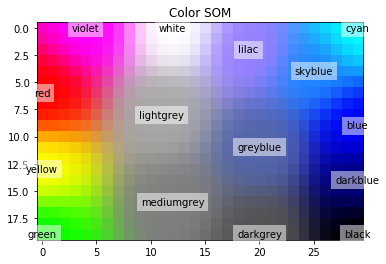

In [110]:
# Testing cell for data in pandas df

#Training inputs for RGBcolors
colorDF = pd.DataFrame(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = ['black', 'blue', 'darkblue', 'skyblue', 'greyblue', 'lilac', 'green', 'red',
               'cyan', 'violet', 'yellow', 'white', 'darkgrey', 'mediumgrey', 'lightgrey']

print str(datetime.datetime.now()),'Training SOM'
#Train a 20x30 SOM with 400 iterations
som = SOM(20, 30, 3, 400)
som.train(colorDF.values)

print str(datetime.datetime.now()),'Getting output grid'
#Get output grid
image_grid = som.get_centroids()
 
print str(datetime.datetime.now()),'Mapping inputs'
#Map colours to their closest neurons
mapped = som.map_to_vector(colorDF.values)
 
print str(datetime.datetime.now()),'Plotting'    
#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))

In [107]:
colorDF = pd.DataFrame(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])

colorDF

,0,1,2
0,0.000,0.000,0.00
1,0.000,0.000,1.00
2,0.000,0.000,0.50
3,0.125,0.529,1.00
4,0.330,0.400,0.67
5,0.600,0.500,1.00
6,0.000,1.000,0.00
7,1.000,0.000,0.00
8,0.000,1.000,1.00
9,1.000,0.000,1.00
